## Imports

In [1]:
import torch
import random

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import transformers
from transformers import AutoTokenizer
from datasets import load_dataset, load_from_disk

import chess
import chess.svg

from math import ceil
from utils.utils import get_stockfish_scores

from IPython.display import SVG, display

In [2]:
board_data = "data/test.csv.gz"
moves_data = "data/subset_games"
stockfish_path = r"C:\Users\barte\Desktop\Studies\chess_bot\PikeBot\engine\stockfish\stockfish-windows-x86-64-avx2.exe"
stockfish = chess.engine.SimpleEngine.popen_uci(stockfish_path)

In [3]:
WHITE = 0
BLACK = 1

## Data

In [4]:
## dataset = load_dataset("adamkarvonen/chess_games") # Big
# dataset = load_dataset("mlabonne/chessllm")

In [5]:
# dataset["train"]

In [6]:
# dataset["train"][0]

In [7]:
# subset = dataset["train"].select(range(1000))
# subset.save_to_disk("data/subset_games")

In [8]:
test_data_moves = load_from_disk(moves_data)
test_data_moves

Dataset({
    features: ['average_elo', 'transcript'],
    num_rows: 1000
})

In [9]:
test_data_moves[0]

{'average_elo': 1500.0,
 'transcript': '1. e4 e5 2. d4 d5 3. exd5 exd4 4. Qxd4 c5 5. Qe4+ Ne7 6. Bg5 f6 7. Nf3 fxg5 8. Nxg5 h6 9. Nh7 Bf5 10. Qe5 Bxh7 11. Nc3 Bxc2 12. Bb5+ Nd7 13. Bxd7+ Qxd7 14. O-O a6 15. Rfe1 b5 16. Ne4 c4 17. d6 Bxe4 18. dxe7 Bxe7 19. Qxe4 Qd2 20. Qxa8+ Kf7 21. Qxh8 Qxb2 22. Rad1 Bc5 23. Rd7+ Kg6 24. Qe8+ Kf5 25. Re4 Qxf2+ 26. Kh1 Qf1# 0-1'}

In [10]:
test_data = pd.read_csv(board_data, compression='gzip')

In [11]:
test_data.sort_values(["game_number", "move_number"])

,game_number,move_number,board,move,legal,stockfish_2,stockfish_5,stockfish_10,real,piece_placement,active_color,castling_availability,en_passant,halfmove_clock,fullmove_number
443,0,1,rnbqkbnr/pppppppp/8/8/8/8/RPPPPPPP/RNBQKBN1 b ...,h1a2,False,NaN,NaN,NaN,False,rnbqkbnr/pppppppp/8/8/8/8/RPPPPPPP/RNBQKBN1,b,Qkq,-,0,1
852,0,1,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,e2e4,True,19.0,7.0,13.0,True,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR,b,KQkq,-,0,1
155,0,2,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,e7e6,True,-37.0,-37.0,-34.0,True,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBNR,w,KQkq,-,0,2
203,0,2,rnbqkbnr/pppppppp/8/6n1/4P3/8/PPPP1PPP/R1BQKBN...,b1g5,False,NaN,NaN,NaN,False,rnbqkbnr/pppppppp/8/6n1/4P3/8/PPPP1PPP/R1BQKBNR,w,KQkq,-,0,2
340,0,3,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,d2d4,True,13.0,9.0,19.0,True,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBNR,b,KQkq,-,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,9,88,8/5pk1/6b1/8/8/Qp3P2/2q3P1/6K1 w - - 2 45,c3c2,True,442.0,312.0,552.0,True,8/5pk1/6b1/8/8/Qp3P2/2q3P1/6K1,w,-,-,2,45
39,9,89,8/5pk1/6b1/8/8/Qp3P2/6P1/6KQ b - - 0 45,c2h1,False,NaN,NaN,NaN,False,8/5pk1/6b1/8/8/Qp3P2/6P1/6KQ,b,-,-,0,45
511,9,89,8/5pk1/6b1/8/8/Qp3P2/2q3PK/8 b - - 3 45,g1h2,True,-644.0,-572.0,-546.0,True,8/5pk1/6b1/8/8/Qp3P2/2q3PK/8,b,-,-,3,45
387,9,90,8/5pk1/6b1/8/8/Qpp5/2q3PK/8 w - - 0 46,f3c3,False,NaN,NaN,NaN,False,8/5pk1/6b1/8/8/Qpp5/2q3PK/8,w,-,-,0,46


## Utils

In [62]:
def show_board(board, size=400):
    display(SVG(chess.svg.board(board=board, size=size)))

def get_n_moves(game_transcript, n=10):
    n_games = n + ceil(n/2)
    try:
        return " ".join(game_transcript.split(" ")[:n_games])
    except IndexError:
        return None
    
def get_state_after_moves(game_transcript, n=10):
    board = chess.Board()
    game_str = get_n_moves(game_transcript, n)
    if game_str is None:
        return None
    
    game = [x for x in game_str.split(" ") if not x[0].isdigit()]
    for move in game:
        board.push_san(move)
        
    return board, game_str

def generate_answer(generator, prompt, max_len=40, num_answers=1):
    return [x["generated_text"] for x in generator(prompt, max_length=max_len, num_return_sequences=num_answers, truncation=True, pad_token_id=generator.tokenizer.eos_token_id)]

def generate_next_moves(moves, generator, tokenizer, answer_length=20, num_answers=1):
    query = f"Provide the next move in the chess game. Only provide the move, no move numbers. {moves}"
    tokens = tokenizer.tokenize(query)

    answers = generate_answer(generator, query, max_len=len(tokens)+answer_length, num_answers=num_answers)
    return [answer[len(query)+1:].strip() for answer in answers]

def get_san_legal_moves(board):
    return [board.san(move) for move in board.legal_moves]

def get_color(board_turn):
    return "WHITE" if chess.WHITE == board_turn else "BLACK"

def get_legal_move_evaluations(board, engine, plot_evaluations=False):
    results = {}
    player = board.turn

    result = stockfish.analyse(board, chess.engine.Limit(time=0.1))
    prev_score = result["score"].pov(color=player).score()
    # print("Score before move:", prev_score)
    results["prev_score"] = prev_score

    moves = []
    scores_diff = []
    for move in get_san_legal_moves(board):
        board_copy = board.copy()
        board_copy.push_san(move)
        
        result = engine.analyse(board_copy, chess.engine.Limit(time=0.05))
        evaluation_score = result["score"].pov(color=player).score()
        
        moves.append(move)
        scores_diff.append(evaluation_score - prev_score)
        # print("Move:", move, "Score:", evaluation_score)

    scores_diff = np.array(scores_diff)
    scores_mean = np.mean(scores_diff)
    scores_min = min(scores_diff)
    scores_max = max(scores_diff)

    move_min = moves[np.argmin(scores_diff)]
    move_max = moves[np.argmax(scores_diff)]

    # print(f"Best move: {move_max}: {scores_max} | Worst move: {move_min}: {scores_min} | Mean score {scores_mean}")
    results["best_move"] = move_max
    results["worst_move"] = move_min
    results["min_score"] = scores_min
    results["max_score"] = scores_max
    results["mean_score"] = scores_mean

    sorted_moves_evaluations = sorted(zip(moves, scores_diff), key=lambda x: x[1], reverse=True)
    sorted_moves, sorted_evaluations = zip(*sorted_moves_evaluations)

    results["sorted_moves"] = list(sorted_moves)
    results["sorted_diff_scores"] = list(sorted_evaluations)

    if plot_evaluations:
        plt.figure(figsize=(14, 5))
        plt.bar(sorted_moves, sorted_evaluations)
        plt.xlabel('Moves')
        plt.ylabel('Score difference')
        plt.title('Sorted Evaluation Differences and Corresponding Moves')
        plt.xticks(rotation=45)
        plt.show()

    return results

def plot_results_hist(scores, min_score, max_score, title=""):
    num_bins = 10
    bin_edges = np.linspace(min_score, max_score, num_bins + 1)

    hist, bins = np.histogram(scores, bins=bin_edges)

    plt.figure(figsize=(5, 4))
    plt.bar(bins[:-1], hist, width=np.diff(bins), align='edge')
    plt.xlabel('Score difference')
    plt.ylabel('Frequency')
    plt.title(f'Histogram {title}')
    plt.grid(axis='y')
    plt.show()

In [13]:
def eval_single_position_bot(board, moves, move_stats, generator, tokenizer, num_answers=100, verbose=False):
    """
    Evaluates multiple answers for a single position

    Parameters:
     - board: chess.Board generated with get_state_after_moves()
     - moves: corresponding moves generated with get_state_after_moves()
     - move_stats: stockfish move evaluations created with get_legal_move_evaluations()
     - generator: generator pipeline
     - tokenizer: tokenizer
     - num_answers: number of evaluated answers
     - verbose: print evaluation info
    """
    performances = {
        "illegal_moves": 0,
        "legal_moves": 0,
        "above_average_moves": 0,
        "worst_moves": 0,
        "best_moves": 0,
        "diff_scores": None
    }
    player = board.turn

    scores = []
    answers = generate_next_moves(moves, generator, tokenizer, answer_length=10, num_answers=num_answers)
    legal_moves = get_san_legal_moves(board)
    for next_moves in answers:
        next_moves = [move for move in next_moves.split(" ") if move[0].isalpha()]

        if len(next_moves) == 0:
            if verbose:
                print("No valid moves")
            performances["illegal_moves"] += 1
            continue

        next_move = next_moves[0]
        if verbose:
            print(f"\nGPT Player: {get_color(player)} | Move(?): {next_move} | In legal moves: {next_move in legal_moves}")

        if next_move in legal_moves:
            performances["legal_moves"] += 1

            board_copy = board.copy()
            board_copy.push_san(next_move)
            result = stockfish.analyse(board_copy, chess.engine.Limit(time=0.1))
            evaluation_score = result["score"].pov(color=player).score()
            evaluation_diff = evaluation_score - move_stats['prev_score']
            
            if verbose:
                print(f" - Score before move: {move_stats['prev_score']}\n - Score after move: {evaluation_score}\n - Is best move: {next_move==move_stats['best_move']}\n - Is worst move: {next_move==move_stats['worst_move']}\n - Is above average move: {evaluation_diff > move_stats['mean_score']}")
            
            scores.append(evaluation_diff)
            if next_move==move_stats['best_move']:
                performances["best_moves"] += 1
            
            if next_move==move_stats['worst_move']:
                performances["worst_moves"] += 1
                
            if evaluation_diff > move_stats['mean_score']:
                performances["above_average_moves"] += 1

        else:
            performances["illegal_moves"] += 1

    performances["diff_scores"] = scores
    return performances


def eval_single_position_random(board, move_stats, num_answers=100, verbose=False):
    """
    Evaluates multiple answers for a single position using a random player

    Parameters:
     - board: chess.Board generated with get_state_after_moves()
     - move_stats: stockfish move evaluations created with get_legal_move_evaluations()
     - num_answers: number of evaluated answers
     - verbose: print evaluation info
    """
    performances_random = {
        "above_average_moves": 0,
        "worst_moves": 0,
        "best_moves": 0,
        "diff_scores": None
    }
    player = board.turn

    scores = []
    legal_moves = get_san_legal_moves(board)
    answers = random.choices(legal_moves, k=num_answers)
    for next_move in answers:
        if verbose:
            print(f"\Random Player: {get_color(player)} | Move(?): {next_move}")

        board_copy = board.copy()
        board_copy.push_san(next_move)
        result = stockfish.analyse(board_copy, chess.engine.Limit(time=0.1))
        evaluation_score = result["score"].pov(color=player).score()
        evaluation_diff = evaluation_score - move_stats['prev_score']
        
        if verbose:
            print(f" - Score before move: {move_stats['prev_score']}\n - Score after move: {evaluation_score}\n - Is best move: {next_move==move_stats['best_move']}\n - Is worst move: {next_move==move_stats['worst_move']}\n - Is above average move: {evaluation_diff > move_stats['mean_score']}")
        
        scores.append(evaluation_diff)
        if next_move==move_stats['best_move']:
            performances_random["best_moves"] += 1
        
        if next_move==move_stats['worst_move']:
            performances_random["worst_moves"] += 1
            
        if evaluation_diff > move_stats['mean_score']:
            performances_random["above_average_moves"] += 1


    performances_random["diff_scores"] = scores
    return performances_random

## Model loading

In [14]:
device_name = torch.cuda.get_device_name(0)
print("Device 0:", device_name)

Device 0: NVIDIA GeForce RTX 3060 Ti


In [15]:
from transformers import pipeline
tokenizer = AutoTokenizer.from_pretrained("gpt2")
generator = pipeline("text-generation", model="gpt2", device=0) # TODO gpt2-xl
generator("Once upon a time,", max_length=40, truncation=True, pad_token_id=generator.tokenizer.eos_token_id)

[{'generated_text': 'Once upon a time, when it was possible, he would not, that is, have a place upon him.\n\nTherefore, in the case of a child who has fallen on his deathbed'}]

In [16]:
generate_answer(generator, "Once upon a time,")

["Once upon a time, the last of the three Jedi were not allowed to enter the Galactic Republic of the Republic. It was an unfortunate defeat, as they didn't really want to stand in the way"]

In [17]:
# from transformers import GPT2LMHeadModel, GPT2Tokenizer

# gpt_model = GPT2LMHeadModel.from_pretrained("gpt2")
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# starting_context = "The GPT model is great"

# input_ids = tokenizer(starting_context, return_tensors="pt").input_ids

# outputs = gpt_model.generate(
#     input_ids,
#     num_beams=2,
#     num_return_sequences=1,
#     no_repeat_ngram_size=1,
# )
# print(tokenizer.decode(outputs[0], skip_special_tokens=True))

#### Forced alternatives could help choosing legal moves

In [18]:
# from transformers import GPT2LMHeadModel, GPT2Tokenizer

# gpt_model = GPT2LMHeadModel.from_pretrained("gpt2")
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# must_contain_token = "best"
# must_contain_alternatives = ["amazing", "wonderful", "beautiful", "exceptional"]


# force_words_ids = [
#     tokenizer([must_contain_token], add_prefix_space=True, add_special_tokens=False).input_ids,
#     tokenizer(must_contain_alternatives, add_prefix_space=True, add_special_tokens=False).input_ids,
# ]

# starting_text = ["The laptop", "The product"]
# input_ids = tokenizer(starting_text, return_tensors="pt").input_ids


# outputs = gpt_model.generate(
#     input_ids,
#     force_words_ids=force_words_ids,
#     num_beams=10,
#     num_return_sequences=1,
#     no_repeat_ngram_size=1,
#     remove_invalid_values=True,
# )
# print(tokenizer.decode(outputs[0], skip_special_tokens=True))
# print(tokenizer.decode(outputs[1], skip_special_tokens=True))

## Evaluation based on previous moves

Assumptions:
- The first move in the answer is the next intended move.

#### TODO ideas:
- [x] - Evaluate multiple answers to the same situation
    - calculate mean score improvement
    - number of worst/best moves
    - compare to stockfish evals
    - number of legal moves
    - compare to performance for situations closer and further from the beginning of the game (longer/shorter prompt moves context)
    
2. Constrict to legal moves by allowing for max length output 2-4 tokens and providing must contain alternatives = legal moves, compare relevant results
3. Compare performance/game to a random move player
4. Run as long as legal move not reached/only for legal moves, append move to prompt and evaluate again
5. Compare results to gpt2-xl
6. Check how many consecutive legal moves can be found with increased max length output
7. Experiment with beam search options

#### Test 1: for a single situation analyse gpt answers

Game 0 | Number of moves: 10 | Evaluated answers: 100


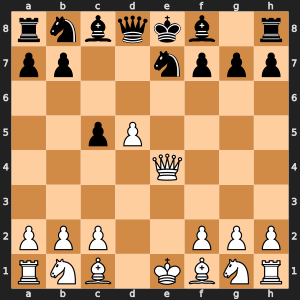

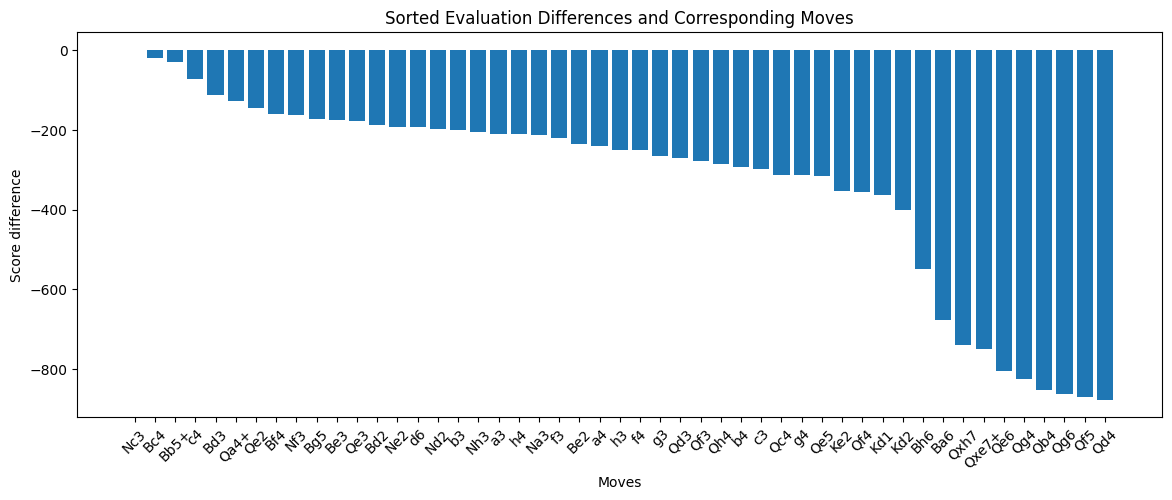


    Worst move: Qd4 score: -877
    Best move: Nc3 score: 2
    Mean score: -331.83673469387753
    
-----------------------------------------------------------------------------------
    GPT2 results:
     - Legal moves made: 16 / 100
     - Number of times the worst move was made: 0
     - Number of times the best move was made: 2
     - Number of times an above average move was made: 16


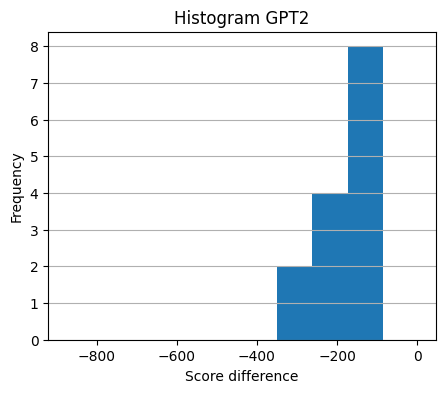

-----------------------------------------------------------------------------------
    Random results:
     - Number of times the worst move was made: 0
     - Number of times the best move was made: 0
     - Number of times an above average move was made: 13


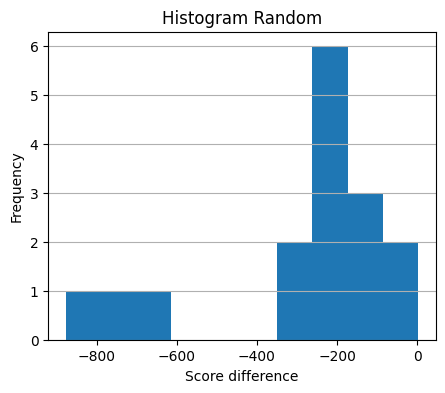

Game 1 | Number of moves: 10 | Evaluated answers: 100


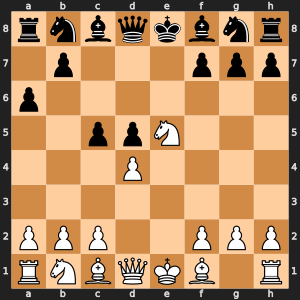

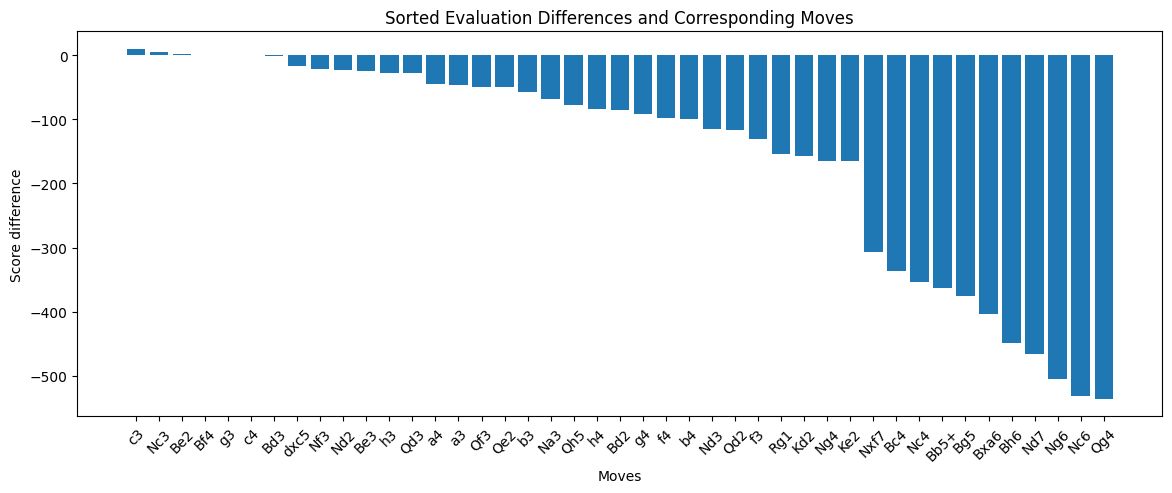


    Worst move: Qg4 score: -536
    Best move: c3 score: 10
    Mean score: -153.58139534883722
    
-----------------------------------------------------------------------------------
    GPT2 results:
     - Legal moves made: 39 / 100
     - Number of times the worst move was made: 1
     - Number of times the best move was made: 0
     - Number of times an above average move was made: 35


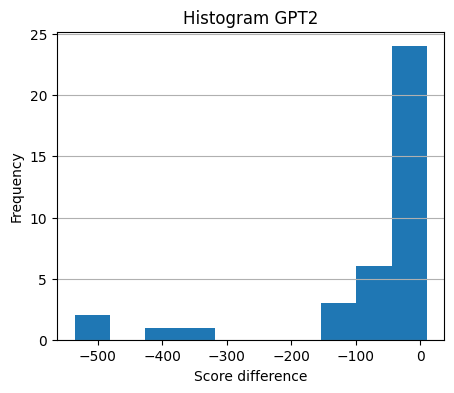

-----------------------------------------------------------------------------------
    Random results:
     - Number of times the worst move was made: 1
     - Number of times the best move was made: 1
     - Number of times an above average move was made: 28


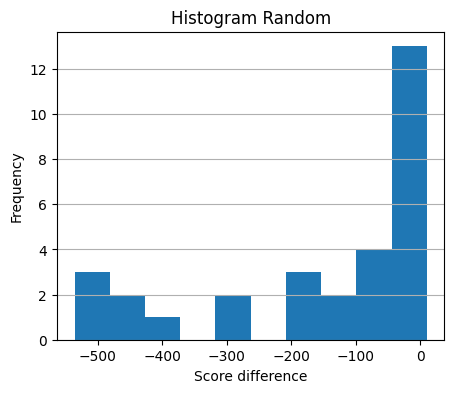

In [64]:
num_moves = 10
num_answers = 100
for i, transcript in enumerate(test_data_moves["transcript"][:2]):
    print("===============================================================================")
    print(f"Game {i} | Number of moves: {num_moves} | Evaluated answers: {num_answers}")
    print("===============================================================================")
    # Get the board and move string after num_moves of the transcripted game
    board, moves = get_state_after_moves(transcript, num_moves)
    show_board(board, 300)

    # Get the stats of possible legal moves
    move_stats = get_legal_move_evaluations(board, stockfish, plot_evaluations=True)
    print(f'''
    Worst move: {move_stats["worst_move"]} score: {move_stats["min_score"]}
    Best move: {move_stats["best_move"]} score: {move_stats["max_score"]}
    Mean difference score: {move_stats["mean_score"]}
    ''')

    # Get stats for gpt model
    performances = eval_single_position_bot(board, moves, move_stats, generator, tokenizer, num_answers=num_answers)
    print(f'''-----------------------------------------------------------------------------------
    GPT2 results:
     - Legal moves made: {performances["legal_moves"]} / {num_answers}
     - Number of times the worst move was made: {performances["worst_moves"]}
     - Number of times the best move was made: {performances["best_moves"]}
     - Number of times an above average move was made: {performances["above_average_moves"]}''')

    plot_results_hist(performances["diff_scores"], move_stats["min_score"], move_stats["max_score"], "GPT2")

    # Get stats for random choice (num repetitions equal to num legal moves made by gpt model)
    performances_random = eval_single_position_random(board, move_stats, performances["legal_moves"])
    print(f'''-----------------------------------------------------------------------------------
    Random results:
     - Number of times the worst move was made: {performances_random["worst_moves"]}
     - Number of times the best move was made: {performances_random["best_moves"]}
     - Number of times an above average move was made: {performances_random["above_average_moves"]}''')

    plot_results_hist(performances_random["diff_scores"], move_stats["min_score"], move_stats["max_score"], "Random")

In [23]:
# transcript = test_data_moves['transcript'][0]
# board, moves = get_state_after_moves(transcript, 3)

# while not board.is_checkmate():
#     next_moves = generate_next_moves(moves, generator, tokenizer)
#     next_move = [move for move in next_moves[0].split(" ") if move[0].isalpha()][0]

#     legal_moves = get_san_legal_moves(board)
#     if next_move in legal_moves:
#         board.push_san(next_move)
#         show_board(board)
#         moves += " " + next_move
#         print(moves)

## Evaluation based on game board

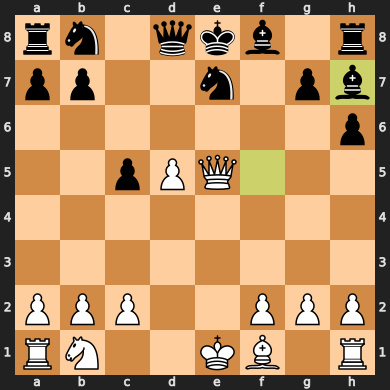

In [18]:
board = chess.Board()
game = test_data_moves[0]["transcript"].split(" ")
res = game[-1]
game = [[x, y] for x, y in zip(game[1::3], game[2::3])]

for turn in game[:10]:
    board.push_san(turn[WHITE])
    board.push_san(turn[BLACK])

board

In [19]:
get_stockfish_scores(board, stockfish, board.turn, time_limit=0.1), "WHITE" if chess.WHITE == board.turn else "BLACK"

((-46, -5, -211), 'WHITE')

In [20]:
generate_answer(generator, f"Provide the next move in the chess game. Only provide the move, no move numbers. {board.fen()}. Next move is A:", max_len=100)

['Provide the next move in the chess game. Only provide the move, no move numbers. rn1qkb1r/pp2n1pb/7p/2pPQ3/8/8/PPP2PPP/RN2KB1R w KQkq - 0 11. Next move is A: Q, A 2 Q P P, Q Z S Y A CQ B Q Y A Q Q B Y B KY D C B']

In [22]:
test_data.board.iloc[0]

'r4b1r/pp1bnkp1/1q2B3/2ppP2p/5P2/2PP1K1P/PP1N4/R1B2R2 b - - 0 19'

In [23]:
board = chess.Board(test_data.board.iloc[0])

print(board)

r . . . . b . r
p p . b n k p .
. q . . B . . .
. . p p P . . p
. . . . . P . .
. . P P . K . P
P P . N . . . .
R . B . . R . .


In [27]:
generate_answer(generator, f"Provide the next move in the chess game. Only provide the move, no move numbers. {board.__str__()}. Next move is A:", max_len=150)

['Provide the next move in the chess game. Only provide the move, no move numbers. r . . . . b . r\np p . b n k p .\n. q . . B . . .\n. . p p P . . p\n. . . . . P . .\n. . P P . K . P\nP P . N . . . .\nR . B . . R . .. Next move is A: b.\n. q b p p p q q p p B: s p p p p p\nB. S. p p p p p v. p p\nS. S.. p p p p P p. P\nS. S..']